<a href="https://colab.research.google.com/github/divilian/frozone/blob/main/Bias_Detection_Using_Various_Projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro**

This is the work I have done in pulling some bias detectors and getting them up and running. The two datasets are also fairly comprehensive which is nice. The only thing that is a little unfortunate is that they are binary detectors but the fairly project does give some more info.

I did this fairly late at night after trying all day to get the whole "clustering word embeddings to detect biased semantic clusters" to work, so I apologize for any weirdness. The short of it is that the clustering idea could work and I found some research that supports the idea that biased words often get clustered together.

Until, and if we don't, get that idea working, my second proposal is just to ensemble a buch of binary classifiers for our bias unit in the "Detector" portion of the project. This seems to be an easy and effective approach to the issue.

# **Dependencies**

In [1]:
# You will need to run this and then restart the notebook before going on. It installs the fairly project
!pip install the-fairly-project --quiet -U
# You will also need to upload the file SBIC.v2.tgz and then execute tar -xvzf SBIC.v2.tgz in the terminal tab

In [2]:
#Be careful to only run this cell once. For whatever reason if you try to run it twice in the same session it breaks
from fairly import TextAnalyzer

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.metrics import f1_score
from datasets import load_dataset
from datasets import Dataset
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# **BABE Dataset**

https://huggingface.co/datasets/mediabiasgroup/BABE

In [4]:
ds = load_dataset("mediabiasgroup/BABE")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'outlet', 'label', 'topic', 'news_link', 'biased_words', 'uuid', 'type', 'label_opinion'],
        num_rows: 3121
    })
    test: Dataset({
        features: ['text', 'outlet', 'label', 'topic', 'news_link', 'biased_words', 'uuid', 'type', 'label_opinion'],
        num_rows: 1000
    })
})

In [5]:
#note a zero label is no bias and a 1 label is biased
BABEdata = ds["train"].to_pandas()
BABEdata

,text,outlet,label,topic,news_link,biased_words,uuid,type,label_opinion
0,NYPD Commissioner Dermot Shea on Monday expres...,Breitbart,0,marriage-equality,http://feedproxy.google.com/~r/breitbart/~3/F5...,[],GtvFWZmmQmybyeMnb8Wbsr,None,Entirely factual
1,School systems across the country are adopting...,Federalist,1,islam,https://thefederalist.com/2020/07/08/black-liv...,"['indoctrinating', 'Marxist', 'alarming']",mvoQPtabs6NZbby6LkLbms,None,Expresses writer’s opinion
2,"And then along came President Barry Obama, who...",Breitbart,1,marriage-equality,http://feedproxy.google.com/~r/breitbart/~3/ks...,"['what', 'the', 'hell']",RDWPbijx3n2aw6NiMHt7di,None,Expresses writer’s opinion
3,"The curfews, which have never before occurred ...",Alternet,1,elections-2020,https://www.alternet.org/2020/06/we-just-got-a...,"['false', 'claims']",2uYKw5KpXasJWH65WCjSu4,left,Entirely factual
4,"Rather than help be a part of the solution, Tr...",Alternet,1,elections-2020,https://www.alternet.org/2020/06/trump-thought...,['racist'],SRGvrzY9PkvtHESdts35Rw,left,Expresses writer’s opinion
...,...,...,...,...,...,...,...,...,...
3116,President Trump is culpable in the preventable...,Alternet,1,environment,https://www.deepl.com/translator#en/ru/Preside...,"['disastrous', 'culpable', 'evisceration']",hT7tLUgbWmP32EAqrSCksL,left,Expresses writer’s opinion
3117,The COVID-19 pandemic may be a unique situatio...,Alternet,0,environment,https://www.alternet.org/2020/06/if-joe-biden-...,[],5Q5MLMs4ZXMUtAjxfrexks,left,Expresses writer’s opinion
3118,China’s state-run propaganda newspaper Global ...,Breitbart,1,black lives matter,http://feedproxy.google.com/~r/breitbart/~3/Dg...,"['propaganda', 'claiming', 'gloated']",cTM4sg944fNrVsPrSssusH,right,Somewhat factual but also opinionated
3119,Yet Biden finds himself in an increasingly com...,Reuters,0,blm,https://www.reuters.com/article/us-usa-electio...,[],Px5X46kNyKvpYDiYmmudrf,None,Entirely factual


# **Social Bias Frames Data**

https://github.com/devitoska/social_bias_frames?tab=readme-ov-file

In [6]:
dev = pd.read_csv("/content/SBIC.v2.agg.dev.csv")
train = pd.read_csv("/content/SBIC.v2.agg.trn.csv")
test = pd.read_csv("/content/SBIC.v2.agg.tst.csv")

# **The Fairly Project**

https://github.com/Ethical-Spectacle/rumormill

In [7]:
analyzer = TextAnalyzer(bias="ternary", classes=True, top_k_classes=3, ner="gus")
result = analyzer.analyze("Tall people are so clumsy.")

Device set to use cuda:0
Device set to use cuda:0


In [8]:
# this is an example of the output from the model some more examples are below
result

{'text': {'text': 'Tall people are so clumsy.',
  'label': 'Slightly Biased',
  'score': 0.6829070448875427,
  'aspects': {'physical': 0.9650779366493225,
   'gender': 0.024978743866086006,
   'socioeconomic': 0.023334762081503868}},
 'ner': [{'token': 'tall', 'labels': ['B-STEREO', 'B-GEN', 'B-UNFAIR']},
  {'token': 'people', 'labels': ['I-STEREO', 'I-GEN', 'I-UNFAIR']},
  {'token': 'are', 'labels': ['I-STEREO']},
  {'token': 'so', 'labels': ['I-STEREO']},
  {'token': 'clumsy', 'labels': ['I-STEREO', 'B-UNFAIR', 'I-UNFAIR']},
  {'token': '.', 'labels': ['I-STEREO', 'I-UNFAIR']}]}

In [9]:
text = "I hate black people"
result = analyzer.analyze(text)
result

{'text': {'text': 'I hate black people',
  'label': 'Slightly Biased',
  'score': 0.7599716186523438,
  'aspects': {'racial': 0.9817771315574646,
   'nationality': 0.05646819621324539,
   'socioeconomic': 0.016729943454265594}},
 'ner': [{'token': 'i', 'labels': ['O']},
  {'token': 'hate', 'labels': ['O']},
  {'token': 'black', 'labels': ['B-STEREO', 'B-GEN']},
  {'token': 'people', 'labels': ['I-STEREO', 'I-UNFAIR']}]}

In [10]:
text = "I love black people"
result = analyzer.analyze(text)
result

{'text': {'text': 'I love black people',
  'label': 'Neutral',
  'score': 0.8876922130584717,
  'aspects': {'racial': 0.9812107086181641,
   'nationality': 0.05141313746571541,
   'socioeconomic': 0.01558646373450756}},
 'ner': [{'token': 'i', 'labels': ['O']},
  {'token': 'love', 'labels': ['O']},
  {'token': 'black', 'labels': ['B-STEREO', 'B-GEN']},
  {'token': 'people', 'labels': ['I-STEREO', 'I-UNFAIR']}]}

In [11]:
text = "hello how are you"
result = analyzer.analyze(text)
result

{'text': {'text': 'hello how are you',
  'label': 'Slightly Biased',
  'score': 0.6876537203788757,
  'aspects': {'physical': 0.1486825793981552,
   'age': 0.037514492869377136,
   'sexuality': 0.026471814140677452}},
 'ner': [{'token': 'hello', 'labels': ['O']},
  {'token': 'how', 'labels': ['O']},
  {'token': 'are', 'labels': ['O']},
  {'token': 'you', 'labels': ['O']}]}

In [12]:
#here and below I am sampling from the training data in social media frames and running it through the analyzer to compare the score metric of the analyzer to the hasBiasedImplication field
sampleFromData = train.sample(frac = 0.1)

In [13]:
i = 0
scores = np.zeros(len(sampleFromData))
for post in sampleFromData["post"]:
  returned = analyzer.analyze(post)
  returned = float(returned["text"]["score"])
  scores[i] += returned
  i += 1
  print(i)

1
2
3
4


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


In [14]:
sampleFromData["The_Fairly_Project_Score"] = scores

<Axes: ylabel='Frequency'>

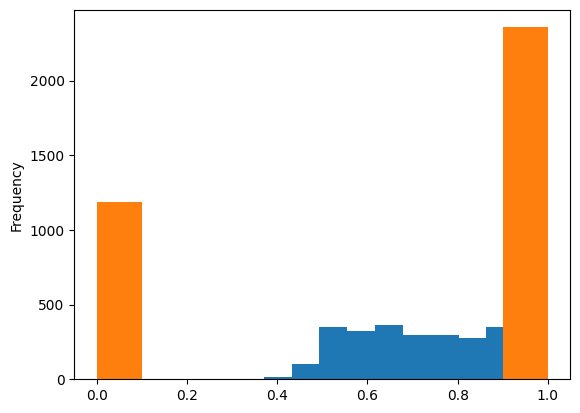

In [15]:
sampleFromData["The_Fairly_Project_Score"].plot(kind="hist")
sampleFromData["hasBiasedImplication"].plot(kind="hist")

In [16]:
f1_score(sampleFromData["hasBiasedImplication"] , np.round(sampleFromData["The_Fairly_Project_Score"]))

0.7827754532775453

A 76.8% f1 score is pretty good for detecting bias. It is also pretty speedy which is nice.

In [17]:
#now we are gonna repeat with the babe dataset
sampleFromBABEDATA = BABEdata.sample(frac = 0.1)

In [18]:
i = 0
scores = np.zeros(len(sampleFromBABEDATA))
for text in sampleFromBABEDATA["text"]:
  returned = analyzer.analyze(text)
  returned = float(returned["text"]["score"])
  scores[i] += returned
  i += 1
  print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [19]:
sampleFromBABEDATA["The_Fairly_Project_Score"] = scores

<Axes: ylabel='Frequency'>

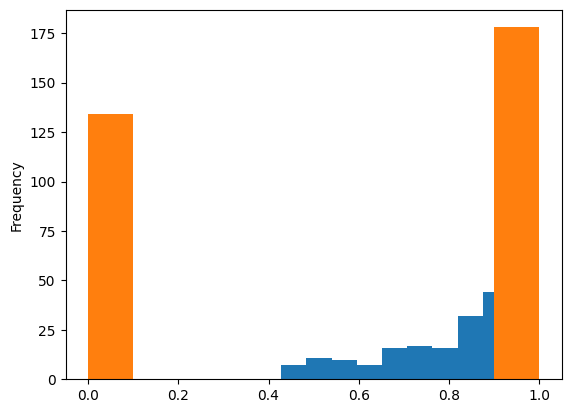

In [20]:
sampleFromBABEDATA["The_Fairly_Project_Score"].plot(kind="hist")
sampleFromBABEDATA["label"].plot(kind="hist")

In [21]:
f1_score(sampleFromBABEDATA["label"] , np.round(sampleFromBABEDATA["The_Fairly_Project_Score"]))

0.7238493723849372

A 72.2% f1 score is pretty good for detecting bias. It is also pretty speedy which is nice.

# **Himel7 bias detector**

https://huggingface.co/himel7/bias-detector?utm_source=chatgpt.com

In [22]:
classifier = pipeline("text-classification", model="himel7/bias-detector", tokenizer="roberta-base")

Device set to use cuda:0


In [23]:
classifier("hello")[0]

{'label': 'LABEL_0', 'score': 0.8789997696876526}

In [24]:
i = 0
scores = np.zeros(len(sampleFromData))
for post in sampleFromData["post"]:
  returned = classifier(post)[0]
  if returned["label"] == "LABEL_0":
    pass
  else:
    scores[i] += 1
  print(i)
  i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
sampleFromData["Himel7_scores"] = scores

<Axes: ylabel='Frequency'>

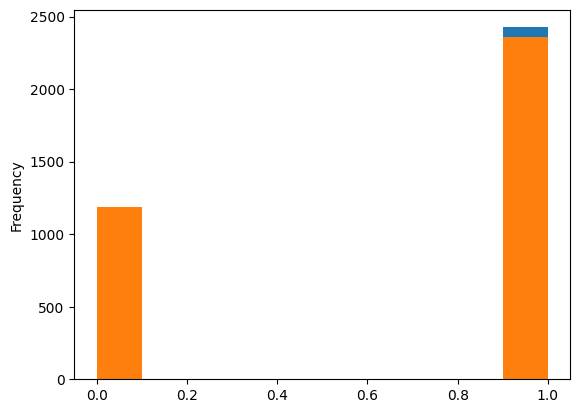

In [26]:
sampleFromData["Himel7_scores"].plot(kind="hist")
sampleFromData["hasBiasedImplication"].plot(kind="hist")

In [27]:
f1_score(sampleFromData["hasBiasedImplication"] , sampleFromData["Himel7_scores"])

0.6523102655237298

63% f1_score is def worse than before. It is important to note that this was significantly faster than the other approach.

In [28]:
i = 0
scores = np.zeros(len(sampleFromBABEDATA))
for text in sampleFromBABEDATA["text"]:
  returned = classifier(text)[0]
  if returned["label"] == "LABEL_0":
    pass
  else:
    scores[i] += 1
  print(i)
  i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
sampleFromBABEDATA["Himel7_scores"] = scores

<Axes: ylabel='Frequency'>

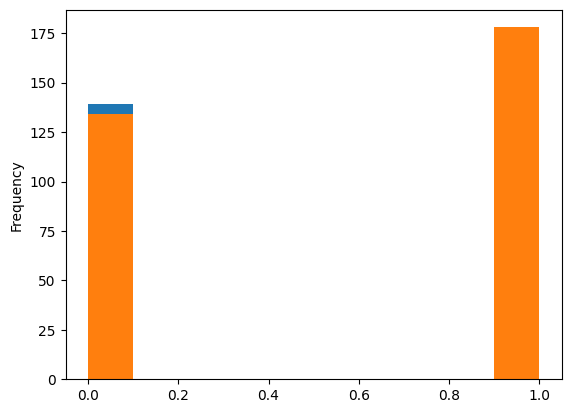

In [30]:
sampleFromBABEDATA["Himel7_scores"].plot(kind="hist")
sampleFromBABEDATA["label"].plot(kind="hist")

In [31]:
f1_score(sampleFromBABEDATA["label"] , np.round(sampleFromBABEDATA["Himel7_scores"]))

0.9572649572649573

94% f1 score is good. Important to note that this is effectively cheating as this model was trained on a subset of this data.

# **Social Media Fairness Classifier**
https://huggingface.co/Social-Media-Fairness/Classifier-Bias-SG?utm_source=chatgpt.com

In [32]:
tokenizer = AutoTokenizer.from_pretrained("Social-Media-Fairness/Classifier-Bias-SG")
model = AutoModelForSequenceClassification.from_pretrained("Social-Media-Fairness/Classifier-Bias-SG")
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
result = classifier("Women are bad driver.")

Device set to use cuda:0


In [33]:
result

[{'label': 'Biased', 'score': 0.6998886466026306}]

In [34]:
i = 0
scores = np.zeros(len(sampleFromData))
for post in sampleFromData["post"]:
  returned = classifier(post)[0]
  if returned["label"] == "Non-biased":
    pass
  else:
    scores[i] += 1
  print(i)
  i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
sampleFromData["SM_Fairness_scores"] = scores

<Axes: ylabel='Frequency'>

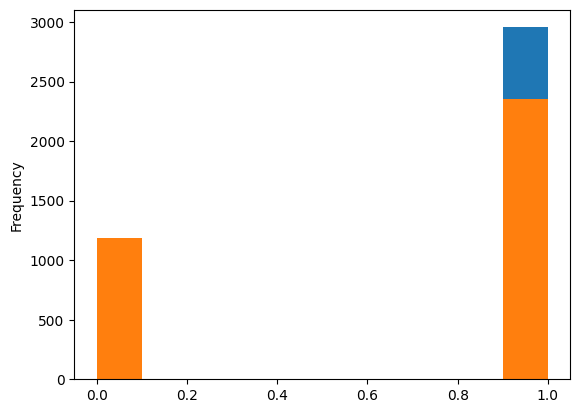

In [36]:
sampleFromData["SM_Fairness_scores"].plot(kind="hist")
sampleFromData["hasBiasedImplication"].plot(kind="hist")

In [37]:
f1_score(sampleFromData["hasBiasedImplication"] , sampleFromData["SM_Fairness_scores"])

0.7058159232072275

In [38]:
i = 0
scores = np.zeros(len(sampleFromBABEDATA))
for text in sampleFromBABEDATA["text"]:
  returned = classifier(text)[0]
  if returned["label"] == "Non-biased":
    pass
  else:
    scores[i] += 1
  print(i)
  i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
sampleFromBABEDATA["SM_Fairness_scores"] = scores

<Axes: ylabel='Frequency'>

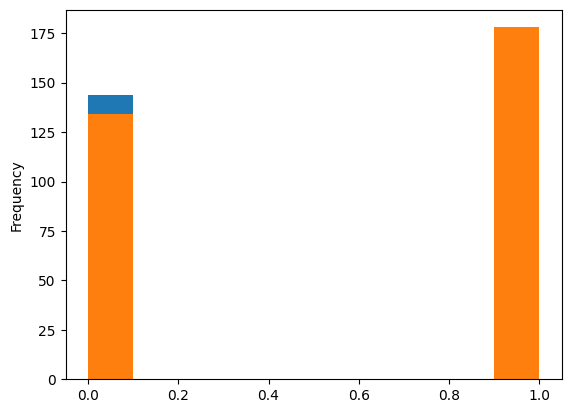

In [40]:
sampleFromBABEDATA["SM_Fairness_scores"].plot(kind="hist")
sampleFromBABEDATA["label"].plot(kind="hist")

In [41]:
f1_score(sampleFromBABEDATA["label"] , np.round(sampleFromBABEDATA["SM_Fairness_scores"]))

0.8728323699421965

Not bad on both counts. I don't think this model beats out the others but because they are all so fast it feels easy to ensemble them. I would need to ensure that the app